# Cholera

In [1]:
import jax
import itertools
import numpy as onp
import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *

import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2023-07-12 09:08:37.969055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
covars = np.array(dataset.values)[:,2:]
gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**-3), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02
gamma = 20.8
epsilon = 19.1
rho = 7.1
delta = 0.02
m = 0.06
c = 0.7
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13
tau = 0.23 
theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs)

In [3]:
theta

Array([ 3.0349529, -2.8134108,  1.9600948,  2.9496884, -4.5      ,
        4.2364893, -4.98     ,  3.5383613,  2.3979158,  0.747    ,
        6.38     , -3.44     ,  4.23     ,  3.33     ,  4.55     ],      dtype=float32)

In [20]:
state = rinit(thetas, 1, covars).squeeze()
keys = np.array([jax.random.PRNGKey(onp.random.choice(10000)) for i in range(2)])
print(rprocess(np.array([state, state]), theta, keys, covars[0])) 
print(rprocesses(np.array([state, state]), np.array([theta, theta]), keys, covars[0]))

[[1533130.8    308666.7    112009.336    2752.8    136564.39   157916.5
   174858.56 ]
 [1840495.8    193755.06    26446.633    2283.573   98795.734  123436.92
   140685.03 ]]
[[1533130.8     308666.7     112009.336     2752.8     136564.39
   157916.5     174858.56  ]
 [1840495.6     193755.1      26446.639     2283.5732   98795.75
   123436.94    140685.05  ]]


In [21]:
print(dmeasure(ys[0], np.vstack([rproc(state+i, theta, keys[0], covars[0]) for i in range(20)]), thetas))
print(dmeasures(ys[0], np.vstack([rproc(state+i, theta, keys[0], covars[0]) for i in range(20)]), 
         np.vstack([thetas+i for i in range(20)])))

[-7.3852262 -7.3852286 -7.385231  -7.3852334 -7.3852363 -7.385238
 -7.3852406 -7.3852434 -7.385246  -7.385248  -7.3852506 -7.3852534
 -7.385256  -7.385258  -7.38526   -7.3852625 -7.3852654 -7.385268
 -7.3852696 -7.385273 ]
[ -7.3852262  -8.371748   -9.369925  -10.369679  -11.369647  -12.369644
 -13.369644  -14.369646  -15.369647  -16.369648  -17.36965   -18.369652
 -19.369654  -20.369654  -21.369656  -22.369658  -23.36966   -24.36966
 -25.369661  -26.369661 ]


In [11]:
def pfilter_monitor(theta, ys, covars=None, J=100, thresh=100):
    
    randint = onp.random.randint(0, 10000)
    particlesF = rinit(theta, J, covars=covars)
    weights = np.log(np.ones(J)/J)
    norm_weights = np.log(np.ones(J)/J)
    
    loglik = 0
    resamples = 0
    lls = []
    pps = []
    pfs = []
    wts = []
    for t in tqdm(range(len(ys))):
        keys = np.array([jax.random.PRNGKey(onp.random.choice(10000)) for j in range(J)])
        # Get prediction particles 
        if covars is not None:
            particlesP = rprocess(particlesF, theta, keys, covars[t])# if t>0 else particlesF
        else:
            particlesP = rprocess(particlesF, theta, keys)
        
        # Resampling condition
        if np.exp(np.max(norm_weights))/np.exp(np.min(norm_weights)) > thresh:
            resamples += 1 #tracker
            # Systematic resampling
            counts = resample(norm_weights)
            particlesF = particlesP[counts]
            weights = norm_weights[counts] - jax.lax.stop_gradient(norm_weights[counts]) - np.log(J)
        else:
            particlesF = particlesP
            weights = norm_weights
            
        # Multiply weights by measurement model result
        keys = np.array([jax.random.PRNGKey(onp.random.choice(10000)) for j in range(J)])
        weights += dmeasure(ys[t], particlesP, theta, keys=keys) #shape (Np,)
        
        # Obtain normalized weights
        norm_weights, loglik_t = normalize_weights(weights)
        pps.append(particlesP)
        pfs.append(particlesF)
        lls.append(loglik_t)
        wts.append(weights)
        
        # Sum up loglik
        loglik += loglik_t
        
    return -loglik, np.array(pps), np.array(pfs), np.array(lls), np.array(wts)

In [12]:
ll, pps, pfs, lls, wts = pfilter_monitor(theta, ys, covars, J=100, thresh=0)

100%|██████████| 600/600 [00:52<00:00, 11.45it/s]


In [18]:
%timeit pfilter(theta, ys, 1000, covars=covars, thresh=0)

322 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def test_pfilter(theta, ys, J, covars=covars, thresh=0):
    theta = theta + (np.abs(theta)/50)*onp.random.normal(theta.shape)
    return pfilter(theta, ys, J, covars=covars, thresh=thresh)

%timeit test_pfilter(theta, ys, 10000, covars=covars, thresh=0)

379 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
pfilter(theta + (np.abs(theta)/100)*onp.random.normal(theta.shape), 
            ys, 10000, covars=covars, thresh=0)

Array(4972.3716, dtype=float32)

In [17]:
perfilter(thetas, ys, 1000, np.abs(thetas)/100, covars=covars, a=0.9, thresh=0)

(Array(6588.1733, dtype=float32),
 Array([[ 1.3373476 , -2.318355  ,  0.5840706 , ...,  0.49656045,
          2.154507  ,  6.633011  ],
        [ 2.1993294 , -2.276998  ,  0.73322004, ...,  1.1930271 ,
          2.1944861 ,  5.8550735 ],
        [ 2.2812858 , -2.4041004 ,  0.7292025 , ...,  1.2318586 ,
          2.2910647 ,  5.836992  ],
        ...,
        [ 2.3420649 , -2.565678  ,  0.80425453, ...,  1.465152  ,
          2.0409455 ,  5.8309636 ],
        [ 2.365928  , -2.5695074 ,  0.8298923 , ...,  1.4675357 ,
          2.0613732 ,  5.963671  ],
        [ 2.351433  , -2.3798764 ,  0.7557837 , ...,  1.3788384 ,
          2.0228431 ,  5.9957204 ]], dtype=float32))

In [ ]:
gamma = np.exp(theta[0]) #rate at which I recovers
m = np.exp(theta[1]) #probability of death from cholera
rho = np.exp(theta[2]) #1/rho is mean duration of short-term immunity
epsilon = np.exp(theta[3]) # 1/eps is mean duration of immunity
omega = np.exp(theta[4]) #mean foi
c = sigmoid(theta[5])/5 #probability exposure infects
beta_trend = theta[6] / 1000 #trend in foi
sigma = theta[7]**2 / 2 #stdev of foi perturbations
tau = theta[8]**2 / 5 #stdev of gaussian measurements
bs = theta[9:] #seasonality coefficients

In [ ]:
n_trials = 1
J = 10000

sigmas = (np.abs(theta)/600)
theta_ests = theta + 12*sigmas*onp.random.normal(size=theta.shape)

'''
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)


newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)

'''
#res = minimize(pfilter, x0=theta_ests, args=(ys, J, covars, 0), method='BFGS', options={'maxiter': 10})

In [ ]:
newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=1000, thresh=0, method='Newton', scale=True, ls=True)

  5%|▌         | 1/20 [01:26<27:24, 86.56s/it]

[ 3.0549874 -2.8787746  2.0214257  2.8400967 -4.5784907  4.191085
 -4.9902096  3.5404007  2.3814483  0.746942   6.3623843 -3.2745357
  4.224572   3.3829622  4.5877104] 0.9 88737.766


 10%|█         | 2/20 [02:17<19:41, 65.61s/it]

[ 3.151789  -2.8320205  2.1844037  2.8433418 -4.4332685  4.2102365
 -5.003916   3.713738   2.648273   0.8925421  7.079718  -3.0966144
  4.2178826  3.3587272  4.3032274] 0.9 46165.12


 15%|█▌        | 3/20 [03:08<16:41, 58.92s/it]

[ 3.2773523 -2.6287508  2.3765454  2.8803236 -4.2347717  4.1799645
 -5.008696   3.40729    3.0238073  1.0819832  7.6031117 -3.3035686
  4.398409   3.5862315  4.254795 ] 0.9 24068.244


 20%|██        | 4/20 [03:59<14:52, 55.77s/it]

[ 3.3532295 -2.5901933  2.4226725  2.7709053 -4.147531   4.180917
 -5.0129538  3.4169233  3.6993632  1.0784279  7.7862887 -3.5387378
  4.8576665  3.738095   4.2961035] 0.9 10498.306


In [ ]:
weighted_newt_logliks, weighted_newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=1000, thresh=0, method='WeightedNewton', scale=True, ls=True)

In [6]:
bfgs_logliks, bfgs_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='BFGS', scale=True, ls=True)

  5%|▌         | 1/20 [00:06<01:54,  6.02s/it]

[ 3.0549874 -2.8787746  2.0214257  2.8400967 -4.5784907  4.191085
 -4.9902096  3.5404007  2.3814483  0.746942   6.3623843 -3.2745357
  4.224572   3.3829622  4.5877104] 0.9 88737.766


 10%|█         | 2/20 [00:11<01:47,  5.99s/it]

[ 2.294391  -2.6337347  2.0239112  2.8403516 -4.334064   4.2034087
 -4.9925303  3.7340813  2.628544   0.787116   6.4008284 -3.2658973
  4.2360706  3.4409776  4.667129 ] 0.225 5107.5625


 15%|█▌        | 3/20 [00:18<01:44,  6.12s/it]

[ 2.0931597 -2.5907874  2.025594   2.840545  -4.291463   4.2068343
 -4.993141   3.7657025  2.6709793  0.8063406  6.419033  -3.2612514
  4.2477646  3.4776251  4.705256 ] 0.0140625 4777.3774


 20%|██        | 4/20 [00:24<01:36,  6.06s/it]

[ 2.082961   -2.5870926   2.0269418   2.841804   -4.2878103   4.20827
 -4.9919314   3.7687342   2.6747196   0.80864024  6.4213147  -3.259729
  4.2496815   3.4807823   4.708447  ] 0.0140625 4768.684


 25%|██▌       | 5/20 [00:30<01:30,  6.03s/it]

[ 2.0816565 -2.583661   2.025898   2.8414295 -4.2824707  4.208253
 -4.991997   3.767689   2.674736   0.8091967  6.4197364 -3.260718
  4.2495437  3.4887185  4.717756 ] 0.9 4762.069


 30%|███       | 6/20 [00:36<01:24,  6.01s/it]

[ 2.0603893  -2.4962392   1.9808216   2.8222022  -4.1083198   4.215289
 -4.989944    3.9181488   2.5312111   0.84974885  6.3137527  -3.3262491
  4.2361693   4.027788    5.364237  ] 0.0140625 4667.1826


 35%|███▌      | 7/20 [00:42<01:18,  6.00s/it]

[ 2.0605843  -2.4970033   1.981531    2.8221183  -4.1115646   4.2148595
 -4.9902434   3.917452    2.535545    0.84736806  6.313072   -3.325757
  4.2378354   4.0211835   5.35357   ] 0.0140625 4665.92


 40%|████      | 8/20 [00:48<01:11,  6.00s/it]

[ 2.0606065  -2.4967916   1.9820465   2.8224745  -4.1137276   4.2148323
 -4.9900837   3.9166784   2.5385435   0.84448165  6.312385   -3.3251054
  4.2391195   4.0144515   5.342308  ] 0.0140625 4664.979


 45%|████▌     | 9/20 [00:54<01:05,  5.99s/it]

[ 2.0605392 -2.4969006  1.9828026  2.8230522 -4.116442   4.214983
 -4.989745   3.9150405  2.5412738  0.8415449  6.3118157 -3.3241944
  4.2409153  4.008331   5.3309627] 0.9 4663.9404


 50%|█████     | 10/20 [01:00<00:59,  5.99s/it]

[ 1.9898081  -2.2816205   2.090364    2.9885662  -3.821305    4.3588157
 -4.9992023   3.751705    2.0433369   0.59401876  6.312612   -3.170206
  4.362406    3.8829505   4.860089  ] 0.0140625 4660.9683


 55%|█████▌    | 11/20 [01:06<00:53,  5.99s/it]

[ 1.9900919 -2.279126   2.0925722  2.9876347 -3.8285115  4.357679
 -4.9994645  3.7520301  2.0478094  0.5943058  6.309574  -3.1714802
  4.364522   3.8771496  4.852136 ] 0.0140625 4659.924


 60%|██████    | 12/20 [01:12<00:47,  5.99s/it]

[ 1.9901713  -2.28024     2.0916924   2.987631   -3.82879     4.357406
 -4.9974318   3.7527506   2.0489695   0.59953606  6.307367   -3.1733527
  4.3618546   3.8804498   4.863791  ] 0.0140625 4660.706


 65%|██████▌   | 13/20 [01:18<00:41,  5.98s/it]

[ 1.9901001 -2.2791755  2.0924926  2.9876244 -3.8286052  4.3576403
 -4.9994097  3.7520678  2.0479236  0.5944827  6.309451  -3.1715555
  4.364584   3.8771117  4.8520136] 0.0140625 4660.92


 70%|███████   | 14/20 [01:24<00:35,  5.98s/it]

[ 1.9900866  -2.2802312   2.0931263   2.987703   -3.8283932   4.357728
 -4.9981427   3.7524438   2.0486865   0.59792113  6.307856   -3.1728148
  4.361467    3.8800287   4.86465   ] 0.0140625 4660.2427


 75%|███████▌  | 15/20 [01:30<00:29,  5.98s/it]

[ 1.9900581 -2.2812283  2.0936854  2.9878383 -3.8282127  4.357888
 -4.996811   3.7528021  2.049428   0.6012469  6.3062735 -3.1739738
  4.358246   3.8829615  4.8773003] 0.0140625 4658.9966


 80%|████████  | 16/20 [01:36<00:23,  5.98s/it]

[ 1.9900217 -2.282248   2.0941956  2.9879973 -3.828009   4.3580565
 -4.995443   3.7531552  2.0501504  0.6045399  6.304638  -3.1751335
  4.355041   3.8858397  4.889966 ] 0.0140625 4657.7544


 85%|████████▌ | 17/20 [01:41<00:17,  5.98s/it]

[ 1.9899158 -2.2835286  2.0943525  2.9883845 -3.827572   4.358337
 -4.9938984  3.7534838  2.0507908  0.6080082  6.30262   -3.1761203
  4.352099   3.8885872  4.9025946] 0.0140625 4657.027


 90%|█████████ | 18/20 [01:47<00:11,  5.98s/it]

[ 1.9899567 -2.2823389  2.09416    2.9882705 -3.8278086  4.3580456
 -4.995296   3.7530975  2.0500157  0.6042095  6.304501  -3.1750772
  4.355146   3.885672   4.8900805] 0.0140625 4657.9663


 95%|█████████▌| 19/20 [01:53<00:05,  5.98s/it]

[ 1.9902264 -2.2821834  2.0919495  2.987953  -3.829127   4.3572636
 -4.994138   3.753824   2.0510347  0.6086712  6.30316   -3.1754782
  4.353617   3.888157   4.9026117] 0.0140625 4657.733


100%|██████████| 20/20 [01:59<00:00,  6.00s/it]

[ 1.989651   -2.2814543   2.0972269   2.9881134  -3.8274515   4.3555117
 -4.988684    3.7531161   2.0494547   0.60125315  6.306424   -3.1786885
  4.352197    3.8867533   4.8955107 ] 0.0140625 4658.296


In [8]:
mif_logliks, mif_params = mif(theta_ests, ys, sigmas=sigmas, 
                              sigmas_init = sigmas, covars=covars,
                              M=20, J=J, a=0.8, monitor=True, thresh=0)

100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


In [12]:
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)

  5%|▌         | 1/20 [00:05<01:46,  5.61s/it]

[ 3.0549874 -2.8787746  2.0214257  2.8400967 -4.5784907  4.191085
 -4.9902096  3.5404007  2.3814483  0.746942   6.3623843 -3.2745357
  4.224572   3.3829622  4.5877104] 8.333333333333333e-07 88737.766


 10%|█         | 2/20 [00:11<01:40,  5.60s/it]

[ 2.6317832 -2.7424319  2.0228088  2.8402386 -4.442489   4.197942
 -4.991501   3.6481667  2.518935   0.7692952  6.3837748 -3.2697291
  4.23097    3.4152427  4.6319   ] 8.333333333333333e-07 8383.598


 15%|█▌        | 3/20 [00:16<01:35,  5.60s/it]

[ 2.6121354  -2.737452    2.0229223   2.8402495  -4.4375525   4.198286
 -4.991579    3.6531475   2.5239666   0.77073085  6.3851557  -3.2693958
  4.2317095   3.4177103   4.6346183 ] 8.333333333333333e-07 7956.157


 20%|██        | 4/20 [00:22<01:29,  5.60s/it]

[ 2.5951326 -2.7330394  2.0230267  2.840261  -4.4331923  4.198588
 -4.991653   3.6573973  2.5284154  0.7719647  6.386337  -3.2691078
  4.2324066  3.4199946  4.6370487] 8.333333333333333e-07 7146.8447


 25%|██▌       | 5/20 [00:27<01:23,  5.60s/it]

[ 2.5818417  -2.7298717   2.023113    2.8402715  -4.430082    4.19882
 -4.9916925   3.6607878   2.5315917   0.77293825  6.3872604  -3.2688825
  4.2329597   3.4217386   4.638871  ] 8.333333333333333e-07 6844.8574


 30%|███       | 6/20 [00:33<01:18,  5.60s/it]

[ 2.5700822  -2.7270322   2.0231986   2.8402812  -4.4272966   4.199026
 -4.9917307   3.663713    2.534443    0.77380776  6.3881187  -3.2686734
  4.233442    3.4233165   4.640519  ] 8.333333333333333e-07 6793.3896


 35%|███▌      | 7/20 [00:39<01:12,  5.60s/it]

[ 2.5590608  -2.7242935   2.0232716   2.8402896  -4.424603    4.1992197
 -4.991763    3.6664348   2.537192    0.77466184  6.3889456  -3.2684772
  4.2338867   3.4247603   4.6420646 ] 8.333333333333333e-07 6615.861


 40%|████      | 8/20 [00:44<01:07,  5.60s/it]

[ 2.5489452  -2.7218769   2.0233448   2.8402975  -4.422228    4.199397
 -4.9917903   3.668932    2.5396192   0.77544105  6.3897038  -3.268296
  4.234307    3.42612     4.6434894 ] 8.333333333333333e-07 6466.4683


 45%|████▌     | 9/20 [00:50<01:01,  5.60s/it]

[ 2.5394905  -2.7195985   2.023409    2.840305   -4.419992    4.1995625
 -4.991817    3.671217    2.5418959   0.77615196  6.390354   -3.2681353
  4.234717    3.4274523   4.6448946 ] 8.333333333333333e-07 6533.5127


 50%|█████     | 10/20 [00:55<00:55,  5.60s/it]

[ 2.5294728 -2.7172263  2.023475   2.840312  -4.4176517  4.199736
 -4.99185    3.6735537  2.5442786  0.7769275  6.3910866 -3.2679558
  4.23516    3.428856   4.646367 ] 8.333333333333333e-07 6301.615


 55%|█████▌    | 11/20 [01:01<00:50,  5.60s/it]

[ 2.52043   -2.715219   2.0235434  2.8403196 -4.4156857  4.19989
 -4.9918804  3.6756377  2.546295   0.7776045  6.391726  -3.2677932
  4.2355876  3.430158   4.6476865] 8.333333333333333e-07 6110.723


 60%|██████    | 12/20 [01:07<00:44,  5.60s/it]

[ 2.5123823 -2.7134218  2.0236034  2.8403265 -4.41393    4.200029
 -4.9919057  3.6775107  2.5480907  0.7782278  6.39233   -3.267644
  4.235957   3.4313207  4.64887  ] 8.333333333333333e-07 6107.122


 65%|██████▌   | 13/20 [01:12<00:39,  5.60s/it]

[ 2.504252  -2.7115762  2.023662   2.8403337 -4.4121294  4.2001677
 -4.9919314  3.6793306  2.5499325  0.7788542  6.392927  -3.267494
  4.2363424  3.4325075  4.6500745] 8.333333333333333e-07 6004.107


 70%|███████   | 14/20 [01:18<00:33,  5.60s/it]

[ 2.4967144 -2.7097976  2.0237148  2.8403397 -4.4103827  4.2002974
 -4.9919505  3.6809995  2.5517077  0.7794643  6.3935113 -3.2673533
  4.236683   3.4335923  4.6512055] 8.333333333333333e-07 6128.963


 75%|███████▌  | 15/20 [01:23<00:27,  5.60s/it]

[ 2.4888015 -2.707834   2.0237658  2.8403456 -4.4084477  4.2004356
 -4.991973   3.6827495  2.5536675  0.7801017  6.3941283 -3.2672026
  4.23705    3.4347515  4.652398 ] 8.333333333333333e-07 5983.867


 80%|████████  | 16/20 [01:29<00:22,  5.59s/it]

[ 2.4818628 -2.7061913  2.023814   2.8403506 -4.4068265  4.200556
 -4.991989   3.6842957  2.5553102  0.7806726  6.3946896 -3.2670658
  4.237358   3.4357357  4.6534386] 8.333333333333333e-07 5835.8037


 85%|████████▌ | 17/20 [01:35<00:16,  5.59s/it]

[ 2.4757679 -2.7048147  2.0238626  2.8403556 -4.4054794  4.2006617
 -4.992006   3.6856654  2.556681   0.781169   6.3951516 -3.2669528
  4.2376413  3.436644   4.6543894] 8.333333333333333e-07 5846.769


 90%|█████████ | 18/20 [01:40<00:11,  5.59s/it]

[ 2.4696515 -2.7033622  2.0239062  2.84036   -4.404048   4.2007675
 -4.9920154  3.687005   2.558132   0.7816621  6.395615  -3.2668383
  4.2379274  3.4375508  4.655334 ] 8.333333333333333e-07 5774.419


 95%|█████████▌| 19/20 [01:46<00:05,  5.59s/it]

[ 2.4632027  -2.7019253   2.0239577   2.840365   -4.402639    4.200877
 -4.9920363   3.6883783   2.5595708   0.78218687  6.3961067  -3.2667148
  4.238244    3.4385204   4.6563306 ] 8.333333333333333e-07 6006.687


100%|██████████| 20/20 [01:51<00:00,  5.60s/it]

[ 2.456246  -2.700233   2.0240064  2.8403704 -4.4009695  4.2009974
 -4.9920635  3.689791   2.5612645  0.782749   6.3965917 -3.2665915
  4.2385798  3.4396298  4.6575217] 8.333333333333333e-07 5889.6113


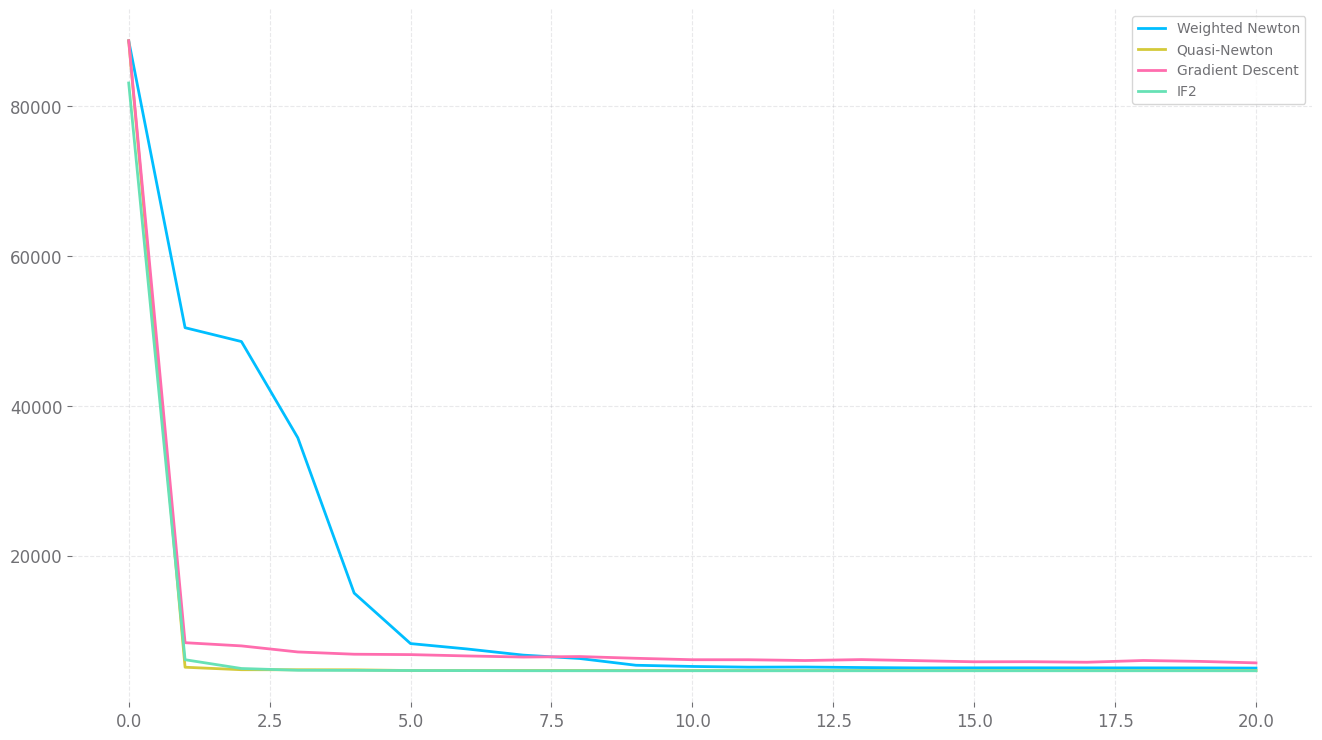

In [31]:
plt.figure(figsize=(16,9))
fro = 0
#plt.plot(newt_logliks, label='Newton')
plt.plot(weighted_newt_logliks[fro:], label='Weighted Newton')
plt.plot(bfgs_logliks[fro:], label='Quasi-Newton')
plt.plot(gd_logliks[fro:], label='Gradient Descent')
plt.plot(mif_logliks[fro:], label='IF2')
plt.legend()
#plt.yscale('log')
#plt.yticks(np.logspace(3,5,10)*3, np.logspace(3,5,10)*3)
plt.show()

In [ ]:
newtif_logliks, newtif_params = newtif(theta_ests, ys, sigmas=np.array([0.001,0.0005,0.0005]), 
                                       sigmas_init = np.array([0.5,0.25,0.25]),
                                       M=10, J=100, a=0.8, beta=0.9, tau=10, monitor=True, thresh=0)
mif_logliks, mif_params = mif(theta_ests, ys, sigmas = np.array([0.001,0.0005,0.0005]), 
                              sigmas_init = np.array([0.5,0.25,0.25]),
                              M=10, J=100, a=0.8, monitor=True, thresh=0)
gd_logliks, gd_ests = train(theta_ests, ys, itns=10, J=100, thresh=0, newt=False)
newt_logliks, newt_ests = train(theta_ests, ys, itns=10, J=100, thresh=0, newt=True)

In [ ]:
plt.plot(np.array(gd_loglik_trials).squeeze())